# MNIST CNN klasifikacija

U ovoj svesci bavićemo se, takođe, zadatkom klasifikacije MNIST slika. U pristupu ćemo koristiti konvolutivne neuronske mreže.

Prvo ćemo učitati sve neophodne biblioteke.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
from tensorflow.keras.datasets import mnist

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [5]:
from tensorflow.keras import utils
from tensorflow.keras import backend as K

In [6]:
np.random.seed(7)

## Korak 1: Učitavanje skupa podataka

Da bismo učitali podatke, iskoristićemo podršku Keras biblioteke.

In [7]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Dimenzije slike ćemo sačuvati na nivou `img_rows` i `img_cols` promenljivih.

In [8]:
img_rows = 28
img_cols = 28

Prilikom obrade slika ulazi u mrežu treba da budu 4D tenzori. Uzimaju se u obzir širina i visina slike, broj kanala (jedan za monohromatske ili tri za RGB slike) i broj instacni. Stoga je učitane podatke potrebno transformisati na ovaj oblik. 

<img src='assets/4D_tensor.png'>

Postoje dve konvencije zapisa slika. `Channels last` zapis je oblika `(samples, height, width, color_depth)`, a `chanell first` oblika `(samples, color_depth, height, width)`. Keras biblioteka (i TensorFlow) podrazumevano koriste `Channel last` zapis. Tako se, na primer, paketić veličine 128 koji sadrži crno-bele slike dimenzija 256x256 opisuje tenzorom dimenzija (128, 256, 256, 1), a recimo, paketić veličine 128 slika koje su u RGB modu tenzorom dimenzija (128, 256, 256, 3).

In [9]:
K.image_data_format()

'channels_last'

Sledeći kod proverava koje od ovih podešavanja važi. U daljem radu se svakako možemo osloniti na podrazumevana podešavanja.

In [10]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [11]:
X_train.shape

(60000, 28, 28, 1)

In [12]:
X_test.shape

(10000, 28, 28, 1)

## Korak 2: Priprema podataka

Slike ćemo pripremiti tako što ćemo ih normalizovati, tj. svesti vrednosti pojedinačnih piksela na vrednost iz intervala iz [0, 1]. Prethodno ćemo promeniti tip elemenata matrice sa uint8 na float32 kako bi mogli da sačuvamo realne vrednosti.

In [13]:
X_train = X_train.astype('float32')
X_train /= 255

In [14]:
X_test = X_test.astype('float32')
X_test /= 255

In [15]:
X_train.shape

(60000, 28, 28, 1)

In [16]:
X_test.shape

(10000, 28, 28, 1)

Vrednosti ciljne promenljive ćemo pripremiti tako što ćemo ih transformisati u vektore dužine 10 sa jedinicom na poziciji koja odgovara vrednosti cifre (takozvano *one-hot* kodiranje). Na primer, broj 3 će biti transformisan u vektor \[0, 0, 0, 1, 0, 0, 0, 0, 0, 0\] sa jedinicom na poziciji tri. 

Za ovu transformaciju iskoristićemo funkciju `to_categorical` paketa `keras.utils`.

In [17]:
number_of_classes = 10

y_train = utils.to_categorical(y_train, number_of_classes)
y_test = utils.to_categorical(y_test, number_of_classes)

## Korak 3: Pravljenje modela

Naš model će se sastojati iz više konvolutivnih i agregacionih slojeva. 

Konvolutivni slojevi se na nivou biblioteke kreiraju korišćenjem funkcije `Conv2D`.  Prvo se navodi broj filtera (parametar `filters`, obično neimenovan), zatim veličine kernela (`kernel_size` parametar), veličina pomeraja (parametar `strides`) i uokvirenje (`padding` parametar). <img src='assets/convolution_operation.gif' style='height: 300px'>

Na primer, na slici je prikazan kernel veličine 3x3 (kvadratić sive boje) koji prolazi kroz ulaz (kvadratić plave boje) sa horizontalnim i vertikalnim pomerajem veličine 2. Dodati beli skup kvadrata predstavlja uokvirenje i u zavisnosti od njegovog prisustva veličina izlazne slike (kvadratić zelene boje) može biti istih dimenzija (u Keras biblioteci se ovo naglašava vrednošću `same` parametra `padding`) ili nešto manja (u Keras biblioteci se ovo naglašava vrednošću `valid` parametra `padding`). 

Agregacioni slojevi (`MaxPooling2D` i `AvgPooling2D`) vrše redukciju slojeva svođenjem blokova zadatih večina na njihove maksimalne ili prosečne vrednosti. Veličina bloka zadaje se parametrom `pool_size`. <img src='assets/pooling.png' style='width: 300px'>

Prilikom treniranja koristićemo i `Dropout` tehniku regularizacije. Podsetimo se da na ovaj način isključujemo nasumično odabrane neurone, omogućavamo drugačiji protok podataka kroz mrežu i smanjujemo zavisnosti izlaza od ulaza. <img src='assets/dropout.png'> Da bi se primenila ova tehnika regularizacije, dovoljno je mreži dodati `Dropout` sloj. Njegov parametar je verovatnoća isključivanja pojedinačnih neurona. 

Sloj ispravljanja, sloj `Flatten`, se korist za transformisanje matrica vrednosti u vektore i obično se koristi kao priprema za prelazak sa konvolutivnog dela na dalji gusti deo mreže. 

Naša mreža imaće sledeću arhitekturu.

In [18]:
model = Sequential([
    Input(shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(number_of_classes, activation='softmax')
])

Prikaz modela i uvid u broj parametara koje mreža treba da nauči možemo da dobijemo pozivom funkcije `summary`.

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

Arhitekturu modela mreže možemo prikazati i u formi usmerenog grafa. Za to će nam trebati biblioteke `pydot` i `graphviz`  koji se mogu instalirati, redom, komandama `conda install -c anaconda pydot` i `conda install -c anaconda graphviz`. Ova dva paketa omogućavaju rad sa `DOT` jezikom koji se koristi za opis grafova. 

In [20]:
import pydot
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

Funkcija `model_to_dot` se koristi za transformisanje modela u `DOT` zapis koji se zatim funkcijom `create` transformiše u SVG sličicu. Za prikaz SVG slika koristimo `display` funkcionalnost IPython-a.

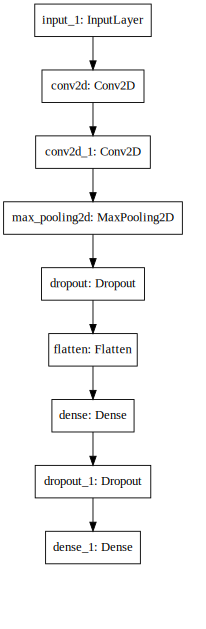

In [21]:
display(SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg')))

Imena slojeva koje koristimo smo mogli naglasiti korišćenjem `name` parametra na nivou slojeva.

Funkcija gubitka koju mreža minimizuje će biti `kategorička unakrsna entropija`. Za treniranje mreže ćemo koristiti optimizator `Adam` sa podešenim korakom učenja. 

In [22]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

Mrežu ćemo trenirati koristeći paketiće veličine 128 u 12 epoha. Treniranje mreže će malo duže trajati.

In [23]:
batch_size = 128
epochs = 12

In [24]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/12
375/375 [==============================] - 115s 306ms/step - loss: 0.2801 - accuracy: 0.9130 - val_loss: 0.0682 - val_accuracy: 0.9808
Epoch 2/12
375/375 [==============================] - 114s 303ms/step - loss: 0.0962 - accuracy: 0.9705 - val_loss: 0.0469 - val_accuracy: 0.9852
Epoch 3/12
375/375 [==============================] - 104s 278ms/step - loss: 0.0687 - accuracy: 0.9795 - val_loss: 0.0419 - val_accuracy: 0.9877
Epoch 4/12
375/375 [==============================] - 96s 256ms/step - loss: 0.0554 - accuracy: 0.9829 - val_loss: 0.0404 - val_accuracy: 0.9883
Epoch 5/12
375/375 [==============================] - 96s 255ms/step - loss: 0.0488 - accuracy: 0.9851 - val_loss: 0.0394 - val_accuracy: 0.9898
Epoch 6/12
375/375 [==============================] - 99s 263ms/step - loss: 0.0433 - accuracy: 0.9862 - val_loss: 0.0365 - val_accuracy: 0.9903
Epoch 7/12
375/375 [==============================] - 100s 268ms/step - loss: 0.0359 - accuracy: 0.9886 - val_loss: 0.0435 - va

Možemo i nacrtati grafike funkcije gubitka i tačnosti u toku treniranja.

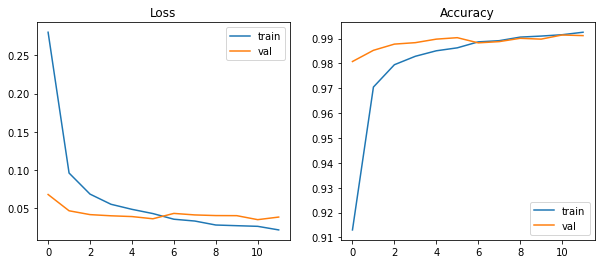

In [25]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='val')
plt.legend(loc='best')

plt.show()

Na osnovu ovih grafika možemo primetiti da smo sa učenjem mogli završiti nešto ranije, na primer, već oko šeste epohe.

## Korak 4: Analiza i evaluacija modela

Mrežu ćemo evaluirati na skupu za testiranje. 

In [26]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03238446265459061
Test accuracy: 0.9902999997138977


Ispisaćemo još matricu konfuzije našeg klasifikatora, kao i klasifikacioni izveštaj.

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

In [28]:
y_predicted = model.predict(X_test)
y_predicted_classes = np.argmax(y_predicted, axis = 1) 

In [29]:
y_predicted_classes.shape

(10000,)

In [30]:
y_test_classes = np.argmax(y_test, axis = 1) 

In [31]:
y_test_classes.shape

(10000,)

In [32]:
confusion_matrix= confusion_matrix(y_test_classes, y_predicted_classes)

In [33]:
print(confusion_matrix)

[[ 975    0    2    1    0    1    1    0    0    0]
 [   0 1134    1    0    0    0    0    0    0    0]
 [   1    2 1023    1    0    0    0    5    0    0]
 [   0    0    3 1004    0    3    0    0    0    0]
 [   1    0    1    0  971    0    1    0    1    7]
 [   0    0    0    6    0  884    1    0    0    1]
 [   4    2    1    0    1    6  942    0    2    0]
 [   0    1    8    0    0    0    0 1018    1    0]
 [   1    0    3    4    0    0    0    2  959    5]
 [   3    1    0    2    3    2    0    3    2  993]]


Možemo primetiti da mreža ponekad meša zapise cifara 0 i 6, 2 i 7, 3 i 5, 2 i 8, ... 

In [34]:
report = classification_report(y_test_classes, y_predicted_classes)

In [35]:
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



Vidimo da je ovaj model, po svojim performansama, bolji od prethodnog model na kojem smo radili.

<div class='alert alert-info'>
    Za dalje istraživanje: 
    <a href='https://cs231n.github.io/convolutional-networks/'> CNN for visual recognition </a>
</div>